In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression

In [63]:
train = pd.read_csv('C:/Users/LENOVO/Downloads/train_dPrl03o/train.csv')

In [58]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d')
df['publish_date_days_since_start'] = (df['publish_date'] - df['publish_date'].min()).dt.days
df['publish_date_day_of_week'] = df['publish_date'].dt.dayofweek
df['publish_date_year'] = df['publish_date'].dt.year
df['publish_date_month'] = df['publish_date'].dt.month

cat_cols = ['category_id', 'country_code', 'channel_title']
num_cols = ['views', 'comment_count', 'likes', 'dislikes']
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])
for c in num_cols:
    df[c] = np.log1p(df[c])
    
df['channel_title_num_videos'] = df['channel_title'].map(df['channel_title'].value_counts())
df['publish_date_num_videos'] = df['publish_date'].map(df['publish_date'].value_counts())
df['channel_in_n_countries'] = df.groupby('channel_title')['country_code'].transform('nunique')

df['channel_title_mean_views'] = df.groupby('channel_title')['views'].transform('mean')
df['channel_title_max_views'] = df.groupby('channel_title')['views'].transform('max')
df['channel_title_min_views'] = df.groupby('channel_title')['views'].transform('min')

df['channel_title_mean_comments'] = df.groupby('channel_title')['comment_count'].transform('mean')
df['channel_title_max_comments'] = df.groupby('channel_title')['comment_count'].transform('max')
df['channel_title_min_comments'] = df.groupby('channel_title')['comment_count'].transform('min')

df['channel_title_mean_dislikes'] = df.groupby('channel_title')['dislikes'].transform('mean')
df['channel_title_max_dislikes'] = df.groupby('channel_title')['dislikes'].transform('max')
df['channel_title_min_dislikes'] = df.groupby('channel_title')['dislikes'].transform('min')

df['title_len'] = df['title'].apply(lambda x: len(x))
df['description_len'] = df['description'].apply(lambda x: len(x))
df['tags_len'] = df['tags'].apply(lambda x: len(x))


ID_COL, TARGET_COL = 'video_id', 'likes'

In [56]:
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [64]:
test =pd.read_csv('C:/Users/LENOVO/Downloads/test_mPTIhGU/test.csv')

In [60]:
test['publish_date'] = pd.to_datetime(test['publish_date'], format='%Y-%m-%d')
test['publish_date_days_since_start'] = (test['publish_date'] - test['publish_date'].min()).dt.days
test['publish_date_day_of_week'] = test['publish_date'].dt.dayofweek
test['publish_date_year'] = test['publish_date'].dt.year
test['publish_date_month'] = test['publish_date'].dt.month

cat_cols = ['category_id', 'country_code', 'channel_title']
num_cols = ['views', 'comment_count', 'likes', 'dislikes']
test[cat_cols] = test[cat_cols].apply(lambda x: pd.factorize(x)[0])
for c in ['views', 'comment_count','dislikes']:
    test[c] = np.log1p(test[c])
    
test['channel_title_num_videos'] = test['channel_title'].map(test['channel_title'].value_counts())
test['publish_date_num_videos'] = test['publish_date'].map(test['publish_date'].value_counts())
test['channel_in_n_countries'] = test.groupby('channel_title')['country_code'].transform('nunique')

test['channel_title_mean_views'] = test.groupby('channel_title')['views'].transform('mean')
test['channel_title_max_views'] = test.groupby('channel_title')['views'].transform('max')
test['channel_title_min_views'] = test.groupby('channel_title')['views'].transform('min')

test['channel_title_mean_comments'] = test.groupby('channel_title')['comment_count'].transform('mean')
test['channel_title_max_comments'] = test.groupby('channel_title')['comment_count'].transform('max')
test['channel_title_min_comments'] = test.groupby('channel_title')['comment_count'].transform('min')

test['channel_title_mean_dislikes'] = df.groupby('channel_title')['dislikes'].transform('mean')
test['channel_title_max_dislikes'] = df.groupby('channel_title')['dislikes'].transform('max')
test['channel_title_min_dislikes'] = df.groupby('channel_title')['dislikes'].transform('min')

test['title_len'] = test['title'].apply(lambda x: len(x))
test['description_len'] = test['description'].apply(lambda x: len(x))
test['tags_len'] = test['tags'].apply(lambda x: len(x))


ID_COL, TARGET_COL = 'video_id', 'likes'

In [41]:
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [7]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
    
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
    return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
df.head()

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,...,channel_title_min_views,channel_title_mean_comments,channel_title_max_comments,channel_title_min_comments,channel_title_mean_dislikes,channel_title_max_dislikes,channel_title_min_dislikes,title_len,description_len,tags_len
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,0,0,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",12.769769,5.700444,6.803505,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,...,11.460505,6.285936,8.293550,4.477337,5.239195,6.486161,3.465736,64,1030,187
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,1,0,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",13.042257,4.317488,5.752573,Vice Ganda notices Bela Padilla's sudden chang...,...,11.018301,4.818890,8.102284,1.945910,4.096210,6.458338,2.197225,55,599,494
2,1856,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n ಕ್...,2,0,2018-03-26,"challenging star darshan latest news|""challeng...",10.601772,5.017280,4.615121,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ ಕ್ಲ...,...,10.601772,3.706186,5.683580,2.302585,4.448197,5.017280,3.828641,100,302,143
3,22618,Havana - swing cover | dodie feat. FLASHBACK,3,1,2018-02-21,"havana|""cover""|""a capella""|""swing""|""dodie""|""fl...",13.141631,6.742881,8.420021,Hi hi hi! here's our vid on FLASHBACK's channe...,...,13.141631,8.420021,8.420021,8.420021,6.742881,6.742881,6.742881,44,751,80
4,74074,MUMMY NE NI KEHTA - 2 FT. 102 NOT OUT| DUDE S...,4,2,2018-05-10,"dude|""seriously""|""friends""|""fun""|""gujarati""|""h...",11.216028,4.248495,5.087596,BOOK YOUR TICKETS HERE: https://goo.gl/QxdSyg...,...,10.678698,5.662853,6.981006,4.795791,4.943231,5.683580,3.931826,54,300,290


In [13]:
test.head()

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,...,channel_title_min_views,channel_title_mean_comments,channel_title_max_comments,channel_title_min_comments,channel_title_mean_dislikes,channel_title_max_dislikes,channel_title_min_dislikes,title_len,description_len,tags_len
0,87185,జనవరి 31 గ్రహణం రోజు కొడుకులు ఉన్నవాళ్లు ఏం చే...,0,0,2018-01-17,"Chirravuri|""Foundation""|""chirravuri foundation...",11.299658,4.007333,4.382027,8885569579...CHIRRAVURI FOUNDATION.\n\n☛Subsct...,...,10.289022,4.348894,6.030685,2.639057,5.239195,6.486161,3.465736,100,333,549
1,9431,ठाणे:'जेव्हा सत्ता बदलेल तेव्हा केस तुमच्यावरह...,1,0,2017-11-18,"Raj Thackeray|""LIVE SPEECH""|""latest Speech""|""r...",11.920508,5.442418,5.743003,Don't Forget to SUBSCIRBE to our YouTube Chann...,...,11.797999,5.857657,6.862758,4.875197,4.096210,6.458338,2.197225,99,4676,537
2,40599,"Thank you, Rider Nation!",2,1,2017-12-01,"Roughriders|""Riders""|""CFL""|""Regina""|""Saskatche...",8.788593,2.397895,2.079442,"“To the devoted, the impassioned, the loyal:\n...",...,8.788593,2.079442,2.079442,2.079442,4.448197,5.017280,3.828641,24,152,130
3,494,Measuring RPM with a spectrum analyzer mobile app,3,2,2018-02-06,"rpm|""woodworking""|""tool speed""|""blade speed""|""...",11.403836,4.983607,5.783825,Using a spectrum analyzer app to analyze the s...,...,11.403836,5.783825,5.783825,5.783825,6.742881,6.742881,6.742881,49,118,97
4,73942,Anchor Anasuya responded on Phone breaking iss...,4,0,2018-02-06,"anasuya responded|""anasuya issue""|""anasuya bor...",10.887941,5.880533,5.036953,Welcome to AVA Creative thoughts Channel Subsc...,...,10.887941,5.036953,5.036953,5.036953,4.943231,5.683580,3.931826,70,136,498


In [72]:
def run_gradient_boosting(clf, fit_params, train, test, features):
    
    N_SPLITS = 5
    oofs = np.zeros(len(train))
    preds = np.zeros((len(test)))

    target = train[TARGET_COL]

    folds = StratifiedKFold(n_splits = N_SPLITS)
    stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

    feature_importances = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
        print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
        X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

        ### Validation Set
        X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

        ### Test Set
        X_test = test[features]

        scaler = StandardScaler()
        _ = scaler.fit(X_trn)

        X_trn = scaler.transform(X_trn)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

        fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
        feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

        ### Instead of directly predicting the classes we will obtain the probability of positive class.
        preds_val = clf.predict(X_val)
        preds_test = clf.predict(X_test)

        fold_score = av_metric(y_val, preds_val)
        print(f'\nAV metric score for validation set is {fold_score}')

        oofs[val_idx] = preds_val
        preds += preds_test / N_SPLITS


    oofs_score = av_metric(target, oofs)
    print(f'\n\nAV metric for oofs is {oofs_score}')

    feature_importances = feature_importances.reset_index(drop = True)
    fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
    fi.plot(kind = 'barh', figsize=(12, 6))

    return oofs, preds, fi


------------- Fold 1 -------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.608287
[200]	valid_0's rmse: 0.567457
[300]	valid_0's rmse: 0.547797
[400]	valid_0's rmse: 0.537037
[500]	valid_0's rmse: 0.53017
[600]	valid_0's rmse: 0.522588
[700]	valid_0's rmse: 0.51707
[800]	valid_0's rmse: 0.512748
[900]	valid_0's rmse: 0.509488
[1000]	valid_0's rmse: 0.506963
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.506963

AV metric score for validation set is 506.9632207391802

------------- Fold 2 -------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.608169
[200]	valid_0's rmse: 0.561762
[300]	valid_0's rmse: 0.542644
[400]	valid_0's rmse: 0.531059
[500]	valid_0's rmse: 0.52345
[600]	valid_0's rmse: 0.517721
[700]	valid_0's rmse: 0.51306
[800]	valid_0's rmse: 0.509615
[900]	valid_0's rmse: 0.50651
[1000]	valid_0's rmse: 0.504445
Did not meet early stopping. Best iteration is:
[10

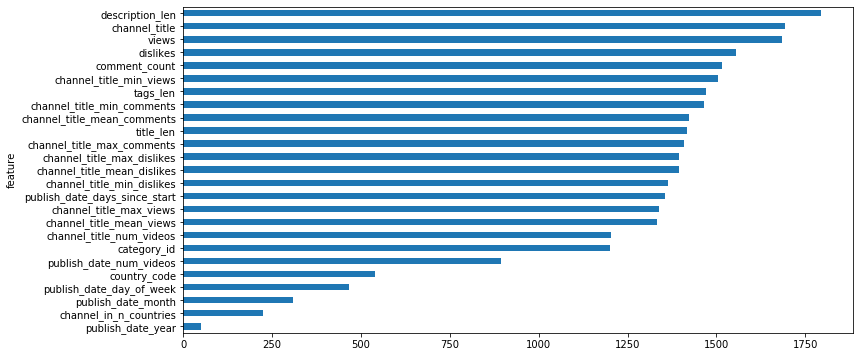

In [44]:
clf = LGBMRegressor(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, df, test, cat_num_cols)

In [33]:
def convert(preds):
    preds = np.expm1(preds)
    preds = pd.Series(preds)
    sub = pd.DataFrame({'video_id':test.video_id})
    sub['likes'] = preds
    return sub

In [45]:
lgb1 = convert(lgb_preds)

In [46]:
lgb1.to_csv('lgb4.csv', index=False)

In [42]:
df.shape

(26061, 31)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [61]:
TOP_N_WORDS = 50

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts = vec.fit_transform(df['description']).toarray()
txt_to_fts.shape

(26061, 50)

In [50]:
TOP_N_WORDS = 50

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts_t = vec.fit_transform(test['description']).toarray()
txt_to_fts_t.shape

(11170, 50)

In [62]:
c = 'description'
txt_fts_names = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_names] = txt_to_fts

KeyError: "None of [Index(['description_word_0_count', 'description_word_1_count',\n       'description_word_2_count', 'description_word_3_count',\n       'description_word_4_count', 'description_word_5_count',\n       'description_word_6_count', 'description_word_7_count',\n       'description_word_8_count', 'description_word_9_count',\n       'description_word_10_count', 'description_word_11_count',\n       'description_word_12_count', 'description_word_13_count',\n       'description_word_14_count', 'description_word_15_count',\n       'description_word_16_count', 'description_word_17_count',\n       'description_word_18_count', 'description_word_19_count',\n       'description_word_20_count', 'description_word_21_count',\n       'description_word_22_count', 'description_word_23_count',\n       'description_word_24_count', 'description_word_25_count',\n       'description_word_26_count', 'description_word_27_count',\n       'description_word_28_count', 'description_word_29_count',\n       'description_word_30_count', 'description_word_31_count',\n       'description_word_32_count', 'description_word_33_count',\n       'description_word_34_count', 'description_word_35_count',\n       'description_word_36_count', 'description_word_37_count',\n       'description_word_38_count', 'description_word_39_count',\n       'description_word_40_count', 'description_word_41_count',\n       'description_word_42_count', 'description_word_43_count',\n       'description_word_44_count', 'description_word_45_count',\n       'description_word_46_count', 'description_word_47_count',\n       'description_word_48_count', 'description_word_49_count'],\n      dtype='object')] are in the [columns]"

In [51]:
txt_fts_names_t = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
test[txt_fts_names_t] = txt_to_fts_t

KeyError: "None of [Index(['description_word_0_count', 'description_word_1_count',\n       'description_word_2_count', 'description_word_3_count',\n       'description_word_4_count', 'description_word_5_count',\n       'description_word_6_count', 'description_word_7_count',\n       'description_word_8_count', 'description_word_9_count',\n       'description_word_10_count', 'description_word_11_count',\n       'description_word_12_count', 'description_word_13_count',\n       'description_word_14_count', 'description_word_15_count',\n       'description_word_16_count', 'description_word_17_count',\n       'description_word_18_count', 'description_word_19_count',\n       'description_word_20_count', 'description_word_21_count',\n       'description_word_22_count', 'description_word_23_count',\n       'description_word_24_count', 'description_word_25_count',\n       'description_word_26_count', 'description_word_27_count',\n       'description_word_28_count', 'description_word_29_count',\n       'description_word_30_count', 'description_word_31_count',\n       'description_word_32_count', 'description_word_33_count',\n       'description_word_34_count', 'description_word_35_count',\n       'description_word_36_count', 'description_word_37_count',\n       'description_word_38_count', 'description_word_39_count',\n       'description_word_40_count', 'description_word_41_count',\n       'description_word_42_count', 'description_word_43_count',\n       'description_word_44_count', 'description_word_45_count',\n       'description_word_46_count', 'description_word_47_count',\n       'description_word_48_count', 'description_word_49_count'],\n      dtype='object')] are in the [columns]"

In [49]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

KeyError: "None of [Index(['description_word_0_count', 'description_word_1_count',\n       'description_word_2_count', 'description_word_3_count',\n       'description_word_4_count', 'description_word_5_count',\n       'description_word_6_count', 'description_word_7_count',\n       'description_word_8_count', 'description_word_9_count',\n       'description_word_10_count', 'description_word_11_count',\n       'description_word_12_count', 'description_word_13_count',\n       'description_word_14_count', 'description_word_15_count',\n       'description_word_16_count', 'description_word_17_count',\n       'description_word_18_count', 'description_word_19_count',\n       'description_word_20_count', 'description_word_21_count',\n       'description_word_22_count', 'description_word_23_count',\n       'description_word_24_count', 'description_word_25_count',\n       'description_word_26_count', 'description_word_27_count',\n       'description_word_28_count', 'description_word_29_count',\n       'description_word_30_count', 'description_word_31_count',\n       'description_word_32_count', 'description_word_33_count',\n       'description_word_34_count', 'description_word_35_count',\n       'description_word_36_count', 'description_word_37_count',\n       'description_word_38_count', 'description_word_39_count',\n       'description_word_40_count', 'description_word_41_count',\n       'description_word_42_count', 'description_word_43_count',\n       'description_word_44_count', 'description_word_45_count',\n       'description_word_46_count', 'description_word_47_count',\n       'description_word_48_count', 'description_word_49_count'],\n      dtype='object')] are in the [columns]"

In [68]:
ID_COL, TARGET_COL = 'video_id', 'likes'

num_cols = ['views', 'dislikes', 'comment_count']
cat_cols = ['category_id', 'country_code', 'channel_title']
text_cols = ['title', 'tags', 'description']
date_cols = ['publish_date']

In [66]:
def join_df(train, test):

    df = pd.concat([train, test], axis=0).reset_index(drop = True)
    features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
    df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

    return df, features

def split_df_and_get_features(df, train_nrows):

    train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
    features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
    return train, test, features

In [67]:
df, features = join_df(train, test)

In [69]:
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d')
df['publish_date_days_since_start'] = (df['publish_date'] - df['publish_date'].min()).dt.days

df['publish_date_day_of_week'] = df['publish_date'].dt.dayofweek
df['publish_date_year'] = df['publish_date'].dt.year
df['publish_date_month'] = df['publish_date'].dt.month

In [70]:
df['channel_title_num_videos'] = df['channel_title'].map(df['channel_title'].value_counts())
df['publish_date_num_videos'] = df['publish_date'].map(df['publish_date'].value_counts())

In [71]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.605903
[600]	valid_0's rmse: 0.580781
[900]	valid_0's rmse: 0.56979
[1200]	valid_0's rmse: 0.562391
[1500]	valid_0's rmse: 0.557347
[1800]	valid_0's rmse: 0.555304
[2100]	valid_0's rmse: 0.55384
[2400]	valid_0's rmse: 0.552948
[2700]	valid_0's rmse: 0.552161
[3000]	valid_0's rmse: 0.551911
[3300]	valid_0's rmse: 0.551635
Early stopping, best iteration is:
[3112]	valid_0's rmse: 0.551525

AV metric score for validation set is 551.5248594123022

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.615302
[600]	valid_0's rmse: 0.591095
[900]	valid_0's rmse: 0.579982
[1200]	valid_0's rmse: 0.572046
[1500]	valid_0's rmse: 0.568732
[1800]	valid_0's rmse: 0.565462
[2100]	valid_0's rmse: 0.564083
[2400]	valid_0's rmse: 0.562824
[2700]	valid_0's rmse: 0.562801
Early stopping, best iteration is:
[2564]	valid_

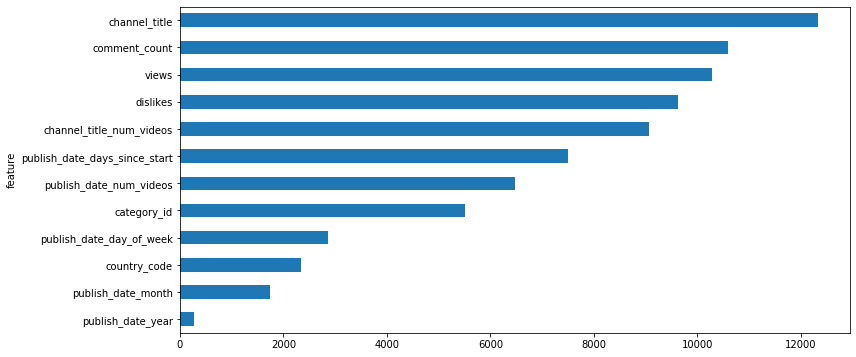

In [73]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [74]:
lgb_preds_t = np.expm1(lgb_preds)

In [75]:
ss = pd.DataFrame({'video_id':test.video_id})
ss['likes'] = lgb_preds_t

In [76]:
ss.head()

,video_id,likes
0,87185,702.927323
1,9431,1938.479475
2,40599,27.143101
3,494,4325.984678
4,73942,663.261185


In [77]:
ss.to_csv('cp_sub1.csv', index=False)

In [78]:
df['channel_in_n_countries'] = df.groupby('channel_title')['country_code'].transform('nunique')

In [79]:
df['channel_title_mean_views'] = df.groupby('channel_title')['views'].transform('mean')
df['channel_title_max_views'] = df.groupby('channel_title')['views'].transform('max')
df['channel_title_min_views'] = df.groupby('channel_title')['views'].transform('min')

df['channel_title_mean_comments'] = df.groupby('channel_title')['comment_count'].transform('mean')
df['channel_title_max_comments'] = df.groupby('channel_title')['comment_count'].transform('max')
df['channel_title_min_comments'] = df.groupby('channel_title')['comment_count'].transform('min')

In [80]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.554372
[600]	valid_0's rmse: 0.528054
[900]	valid_0's rmse: 0.51635
[1200]	valid_0's rmse: 0.509743
[1500]	valid_0's rmse: 0.504697
[1800]	valid_0's rmse: 0.502617
[2100]	valid_0's rmse: 0.501062
[2400]	valid_0's rmse: 0.500082
[2700]	valid_0's rmse: 0.499561
[3000]	valid_0's rmse: 0.498623
[3300]	valid_0's rmse: 0.498473
Early stopping, best iteration is:
[3396]	valid_0's rmse: 0.498207

AV metric score for validation set is 498.2065643108733

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.552325
[600]	valid_0's rmse: 0.529039
[900]	valid_0's rmse: 0.52033
[1200]	valid_0's rmse: 0.514794
[1500]	valid_0's rmse: 0.512152
[1800]	valid_0's rmse: 0.510433
[2100]	valid_0's rmse: 0.508673
[2400]	valid_0's rmse: 0.507527
[2700]	valid_0's rmse: 0.506332
[3000]	valid_0's rmse: 0.506293
[3300]	valid_0's

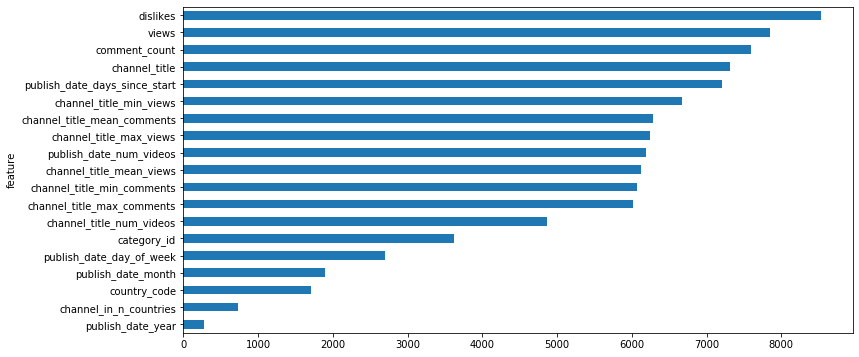

In [81]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [82]:
lgb_preds_t1 = np.expm1(lgb_preds)

In [83]:
ss1 = pd.DataFrame({'video_id':test.video_id})
ss1['likes'] = lgb_preds_t1

In [84]:
ss1.to_csv('cp_sub2.csv', index=False)

In [85]:
df1 = df.copy()

In [86]:
df1['channel_title_mean_dislikes'] = df1.groupby('channel_title')['dislikes'].transform('mean')
df1['channel_title_max_dislikes'] = df1.groupby('channel_title')['dislikes'].transform('max')
df1['channel_title_min_dislikes'] = df1.groupby('channel_title')['dislikes'].transform('min')

In [87]:
train_proc, test_proc, features = split_df_and_get_features(df1, train.shape[0])
features = [c for c in df1.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.547648
[600]	valid_0's rmse: 0.521024
[900]	valid_0's rmse: 0.511328
[1200]	valid_0's rmse: 0.505995
[1500]	valid_0's rmse: 0.502255
[1800]	valid_0's rmse: 0.500578
[2100]	valid_0's rmse: 0.498879
[2400]	valid_0's rmse: 0.498284
[2700]	valid_0's rmse: 0.497593
[3000]	valid_0's rmse: 0.497134
[3300]	valid_0's rmse: 0.497108
Early stopping, best iteration is:
[3106]	valid_0's rmse: 0.496986

AV metric score for validation set is 496.9861662649989

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.545758
[600]	valid_0's rmse: 0.522775
[900]	valid_0's rmse: 0.510802
[1200]	valid_0's rmse: 0.50523
[1500]	valid_0's rmse: 0.50173
[1800]	valid_0's rmse: 0.499518
[2100]	valid_0's rmse: 0.498372
[2400]	valid_0's rmse: 0.497432
[2700]	valid_0's rmse: 0.49688
[3000]	valid_0's rmse: 0.496214
[3300]	valid_0's 

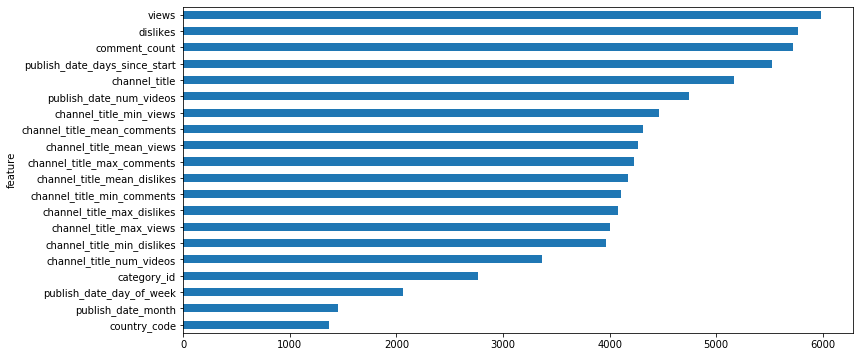

In [88]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [89]:
lgb_preds_t2 = np.expm1(lgb_preds)
ss2 = pd.DataFrame({'video_id':test.video_id})
ss2['likes'] = lgb_preds_t2


In [90]:
ss2.to_csv('cp_sub3.csv', index=False)

In [91]:
df = df1.copy()

In [92]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['description_len'] = df['description'].apply(lambda x: len(x))
df['tags_len'] = df['tags'].apply(lambda x: len(x))

In [93]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.540412
[600]	valid_0's rmse: 0.513004
[900]	valid_0's rmse: 0.501279
[1200]	valid_0's rmse: 0.495352
[1500]	valid_0's rmse: 0.491663
[1800]	valid_0's rmse: 0.489275
[2100]	valid_0's rmse: 0.487916
[2400]	valid_0's rmse: 0.48695
[2700]	valid_0's rmse: 0.485938
[3000]	valid_0's rmse: 0.485122
[3300]	valid_0's rmse: 0.484696
[3600]	valid_0's rmse: 0.484301
[3900]	valid_0's rmse: 0.484082
Early stopping, best iteration is:
[3844]	valid_0's rmse: 0.483995

AV metric score for validation set is 483.9953046600249

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.543616
[600]	valid_0's rmse: 0.518238
[900]	valid_0's rmse: 0.507055
[1200]	valid_0's rmse: 0.50126
[1500]	valid_0's rmse: 0.497136
[1800]	valid_0's rmse: 0.494228
[2100]	valid_0's rmse: 0.492849
[2400]	valid_0's rmse: 0.491014
[2700]	valid_0's

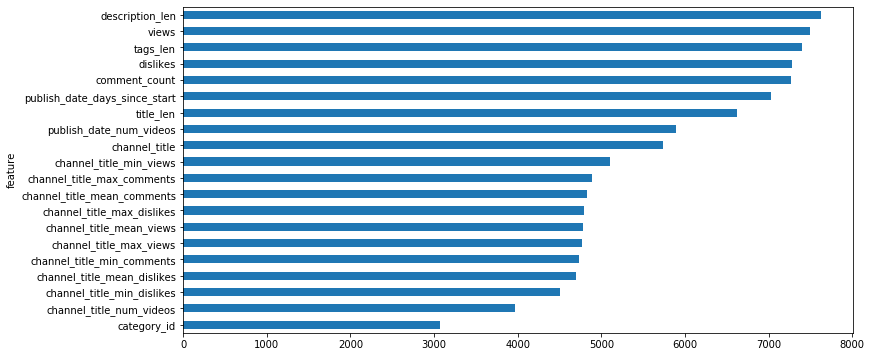

In [94]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [95]:
lgb_preds_t3 = np.expm1(lgb_preds)
ss3 = pd.DataFrame({'video_id':test.video_id})
ss3['likes'] = lgb_preds_t3
ss3.to_csv('cp_sub4.csv', index=False)

In [110]:
df.head()

,category_id,channel_title,comment_count,country_code,description,dislikes,likes,publish_date,tags,title,...,channel_title_min_views,channel_title_mean_comments,channel_title_max_comments,channel_title_min_comments,channel_title_mean_dislikes,channel_title_max_dislikes,channel_title_min_dislikes,title_len,description_len,tags_len
0,0,0,6.803505,0,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,5.700444,7.763021,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,...,11.460505,6.271691,8.293550,4.477337,5.166463,6.486161,3.465736,64,1030,187
1,0,1,5.752573,0,Vice Ganda notices Bela Padilla's sudden chang...,4.317488,8.091015,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",It's Showtime Miss Q & A: Bela gets jealous of...,...,11.018301,4.973893,8.666303,1.945910,4.175200,7.572503,2.197225,55,599,494
2,0,2,4.615121,1,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ ಕ್ಲ...,5.017280,6.364751,2018-03-26,"challenging star darshan latest news|""challeng...",ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n ಕ್...,...,9.623046,3.548825,5.683580,2.302585,3.934995,5.017280,0.693147,100,302,143
3,1,3,8.420021,2,Hi hi hi! here's our vid on FLASHBACK's channe...,6.742881,11.323869,2018-02-21,"havana|""cover""|""a capella""|""swing""|""dodie""|""fl...",Havana - swing cover | dodie feat. FLASHBACK,...,12.369054,8.251521,8.420021,8.083020,5.632335,6.742881,4.521789,44,751,80
4,2,4,5.087596,1,BOOK YOUR TICKETS HERE: https://goo.gl/QxdSyg...,4.248495,8.176954,2018-05-10,"dude|""seriously""|""friends""|""fun""|""gujarati""|""h...",MUMMY NE NI KEHTA - 2 FT. 102 NOT OUT| DUDE S...,...,10.678698,5.670808,6.981006,4.795791,5.018877,5.683580,3.931826,54,300,290


In [111]:
df1 = df.copy()

In [131]:
df = df1.copy()

In [125]:
df["RANK_category_views"] = df.groupby(['category_id','views'])['category_id'].rank(method="first", ascending=True)
df["RANK_channel_views"] = df.groupby(['channel_title','views'])['channel_title'].rank(method="first", ascending=True)
#df["RANK_category_cmnt"] = df.groupby(['category_id','comment_count'])['category_id'].rank(method="first", ascending=True)
#df["RANK_channel_cmnt"] = df.groupby(['channel_title','comment_count'])['channel_title'].rank(method="first", ascending=True)


In [126]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.53636
[600]	valid_0's rmse: 0.512013
[900]	valid_0's rmse: 0.50411
[1200]	valid_0's rmse: 0.498835
[1500]	valid_0's rmse: 0.496112
[1800]	valid_0's rmse: 0.493904
[2100]	valid_0's rmse: 0.492753
[2400]	valid_0's rmse: 0.49193
[2700]	valid_0's rmse: 0.491564
[3000]	valid_0's rmse: 0.491386
[3300]	valid_0's rmse: 0.491168
[3600]	valid_0's rmse: 0.490783
Early stopping, best iteration is:
[3623]	valid_0's rmse: 0.490728

AV metric score for validation set is 490.72847079404863

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds
[300]	valid_0's rmse: 0.535603
[600]	valid_0's rmse: 0.511789
[900]	valid_0's rmse: 0.502218
[1200]	valid_0's rmse: 0.496961
[1500]	valid_0's rmse: 0.49395
[1800]	valid_0's rmse: 0.491989
[2100]	valid_0's rmse: 0.490569
[2400]	valid_0's rmse: 0.489511
[2700]	valid_0's rmse: 0.488916
[3000]	valid_0's 

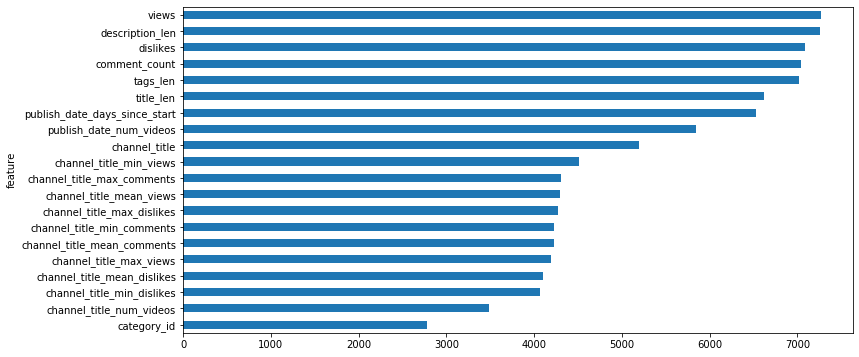

In [130]:
clf = LGBMRegressor(n_estimators = 4800,
                        learning_rate = 0.06,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [96]:
from sklearn.feature_extraction.text import CountVectorizer

In [106]:
TOP_N_WORDS = 50

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts = vec.fit_transform(df['description']).toarray()
txt_to_fts.shape

(37231, 50)

In [109]:
c = 'description'
txt_fts_names = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]

In [ ]:
df[txt_fts_names] = txt_to_fts

In [104]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

KeyError: "None of [Index(['description_word_0_count', 'description_word_1_count',\n       'description_word_2_count', 'description_word_3_count',\n       'description_word_4_count', 'description_word_5_count',\n       'description_word_6_count', 'description_word_7_count',\n       'description_word_8_count', 'description_word_9_count',\n       'description_word_10_count', 'description_word_11_count',\n       'description_word_12_count', 'description_word_13_count',\n       'description_word_14_count', 'description_word_15_count',\n       'description_word_16_count', 'description_word_17_count',\n       'description_word_18_count', 'description_word_19_count',\n       'description_word_20_count', 'description_word_21_count',\n       'description_word_22_count', 'description_word_23_count',\n       'description_word_24_count', 'description_word_25_count',\n       'description_word_26_count', 'description_word_27_count',\n       'description_word_28_count', 'description_word_29_count',\n       'description_word_30_count', 'description_word_31_count',\n       'description_word_32_count', 'description_word_33_count',\n       'description_word_34_count', 'description_word_35_count',\n       'description_word_36_count', 'description_word_37_count',\n       'description_word_38_count', 'description_word_39_count',\n       'description_word_40_count', 'description_word_41_count',\n       'description_word_42_count', 'description_word_43_count',\n       'description_word_44_count', 'description_word_45_count',\n       'description_word_46_count', 'description_word_47_count',\n       'description_word_48_count', 'description_word_49_count'],\n      dtype='object')] are in the [columns]"

In [108]:
txt_fts_names[:5]

0    description_word_0_count
1    description_word_1_count
2    description_word_2_count
3    description_word_3_count
4    description_word_4_count
dtype: object

In [132]:
df1.columns

Index(['category_id', 'channel_title', 'comment_count', 'country_code',
       'description', 'dislikes', 'likes', 'publish_date', 'tags', 'title',
       'video_id', 'views', 'publish_date_days_since_start',
       'publish_date_day_of_week', 'publish_date_year', 'publish_date_month',
       'channel_title_num_videos', 'publish_date_num_videos',
       'channel_in_n_countries', 'channel_title_mean_views',
       'channel_title_max_views', 'channel_title_min_views',
       'channel_title_mean_comments', 'channel_title_max_comments',
       'channel_title_min_comments', 'channel_title_mean_dislikes',
       'channel_title_max_dislikes', 'channel_title_min_dislikes', 'title_len',
       'description_len', 'tags_len'],
      dtype='object')

In [133]:
df.to_csv('Predata.csv', index=False)